# Proposed Pipeline Analysis


In [ ]:
from pathlib import Path
import seaborn as sn
import os
import sys
sys.path.append(str(Path.cwd().parent))
from src.utils.gcs_utils import set_environement_variable
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

is_env_variables_set = set_environement_variable()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'path to auth.json file'

from src.utils import envs 
e=envs.Envs()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In this notebook, we analyse the proposed pipeline analysis.Please note that the third classifier can have 40 or 41 diseases (if we inlcude acne scars). 

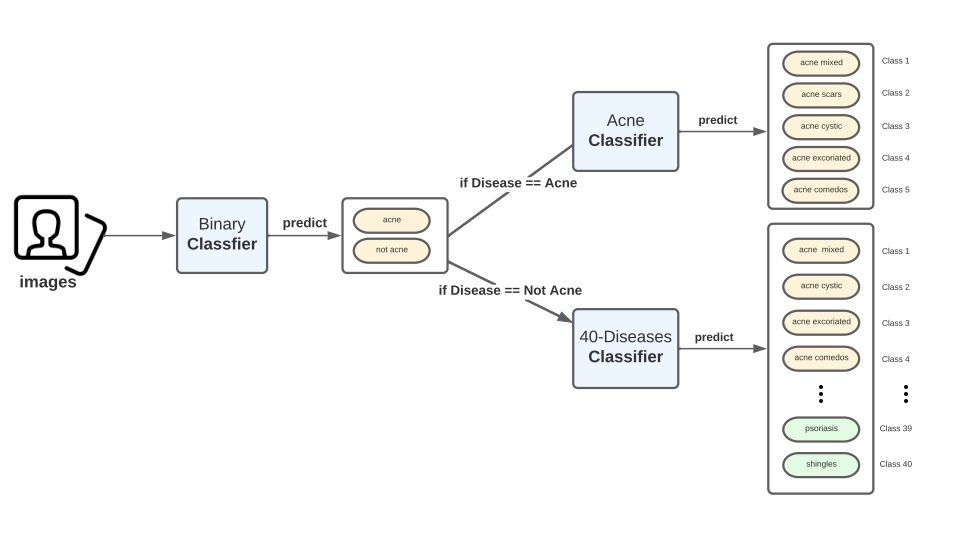


# 1. Identify the images from the training set

Here, we want to identify the images that were used to train the 40 diseases classifier -> is_train=True



In [437]:
#40 diseases test set predictions: gs://oro-ds-test-bucket/sdd_acne_files/models/dl/results/test_set_predictions_102.csv
#40 diseases train set: gs://oro-ds-test-bucket/sdd_acne_files/models/dl/results/train_set_initial_102.csv

In [312]:
def remove_filename_prefix(df, prefix):
    df.filename=df.filename.str.replace(prefix, '')
    return df[~df.duplicated(subset=['filename'], keep='last')]
    

## 1.1 Read 40-diseases classifier files

In [3]:
test_set_40_path = input("Please give the full path to the 40 diseases test set predictions csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv')")
print(f'The 40 diseases classifier test set is located here: {test_set_40_path}')
train_set_40_path = input("Please give the full path to the 40 diseases train csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv')")
print(f'The 40 diseases clasifier train set is located here: {train_set_40_path}')

Please give the full path to the 40 diseases test set predictions csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv') gs://oro-ds-test-bucket/sdd_acne_files/models/dl/results/test_set_predictions_102.csv


The 40 diseases classifier test set is located here: gs://oro-ds-test-bucket/sdd_acne_files/models/dl/results/test_set_predictions_102.csv


Please give the full path to the 40 diseases train csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv') gs://oro-ds-test-bucket/sdd_acne_files/models/dl/results/train_set_initial_102.csv


The 40 diseases clasifier train set is located here: gs://oro-ds-test-bucket/sdd_acne_files/models/dl/results/train_set_initial_102.csv


In [547]:
# create dataframes from csv files
test_set_40 = pd.read_csv(test_set_40_path, index_col=0)
test_set_40.drop(columns=['Pred1', 'Pred2', 'Pred3'], inplace=True)
test_set_40.rename(columns={"label": "labels", 'resnext101_64x4dPred1': 'Pred1', 'resnext101_64x4dPred2': 'Pred2', 'resnext101_64x4dPred3': 'Pred3'}, inplace= True)
print(f'There is {test_set_40.shape[0]} images in the test set.')
test_set_40 = remove_filename_prefix(test_set_40, 'resized/')

There is 1630 images in the test set.


In [548]:
train_set_40 = pd.read_csv(train_set_40_path, index_col=0)
train_set_40 = remove_filename_prefix(train_set_40, 'resized/')
print(f'{train_set_40.shape[0]} images were used to train the 40 diseases classifier.')
test_set_40['is_train_40'] = False

6519 images were used to train the 40 diseases classifier.


## 1.2 Read Binary classifier files

In [92]:
# binary test set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-test_predictions.csv
# binary train set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-train_predictions.csv

# binary test set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/8eeddbb230b746c99eadf97e028a795b/artifacts/files/bit-1-test_predictions.csv
# binary train set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/8eeddbb230b746c99eadf97e028a795b/artifacts/files/bit-1-train_predictions.csv

In [134]:
df_preds_path = input("Please give the full path to the binary classifier test set predictions csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv')")
print(f'The binary classifier test set is located here: {df_preds_path}')
df_train_binary_path = input("Please give the full path to the binary classifier train csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv')")
print(f'The binary classifier train set is located here: {train_set_40_path}')

Please give the full path to the binary classifier test set predictions csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv') gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-test_predictions.csv


The binary classifier test set is located here: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-test_predictions.csv


Please give the full path to the binary classifier train csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv') gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/58d36d6e59604d1d83cf1b3c36298b89/artifacts/files/bit-0-train_predictions.csv


The binary classifier train set is located here: gs://oro-ds-test-bucket/sdd_acne_files/models/dl/results/train_set_initial_102.csv


In [549]:
df_preds= pd.read_csv(df_preds_path)
df_train_binary = pd.read_csv(df_train_binary_path)
df_preds = remove_filename_prefix(df_preds, 'resized/')
df_train_binary = remove_filename_prefix(df_train_binary, 'resized/')
print(f'{df_train_binary.shape[0]} images were used to train the binary classifier.')

8880 images were used to train the binary classifier.


In [550]:
# identify images used to train model
masks_binary= df_preds['filename'].apply(lambda x: x in df_train_binary['filename'].values)
df_preds['is_train_binary'] = masks_binary

## 1.3 Read Acne classifier files

Here, we want to identify all the images used to train the acne classifier. 

In [137]:
# acne classfier test set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/5c3112d673ca4cf4a9c85cc9ac402f93/artifacts/files/bit-inference_predictions.csv
# acne classifier train set: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/c1d5bc156ef8408ca81e40dc020e0b99/artifacts/files/bit-0-train_predictions.csv

In [290]:
df_preds_acne_path = input("Please give the full path to the acne classifier test set predictions csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv')")
print(f'The acne classifier test set is located here: {df_preds_acne_path}')
df_train_acne_path = input("Please give the full path to the acne classifier train csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv')")
print(f'The acne classifier train is located here: {df_train_acne_path}')

Please give the full path to the acne classifier test set predictions csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv') gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/5c3112d673ca4cf4a9c85cc9ac402f93/artifacts/files/bit-inference_predictions.csv


The acne classifier test set is located here: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/5c3112d673ca4cf4a9c85cc9ac402f93/artifacts/files/bit-inference_predictions.csv


Please give the full path to the acne classifier train csv file located in a google bucket (e.g. gs://oro-ds-test-bucket/file.csv') gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/c1d5bc156ef8408ca81e40dc020e0b99/artifacts/files/bit-0-train_predictions.csv


The acne classifier train is located here: gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/c1d5bc156ef8408ca81e40dc020e0b99/artifacts/files/bit-0-train_predictions.csv


In [551]:
df_preds_acne = pd.read_csv(df_preds_acne_path)
df_train_acne = pd.read_csv(df_train_acne_path)
df_preds_acne = remove_filename_prefix(df_preds_acne, 'resized/')
df_train_acne  = remove_filename_prefix(df_train_acne, 'resized/')
print(f'{df_train_acne.shape[0]} images were used to train the acne classifier.')

1720 images were used to train the acne classifier.


In [552]:
masks_acne= df_preds_acne['filename'].apply(lambda x: x in df_train_acne['filename'].values)
df_preds_acne['is_train_acne'] = masks_acne

# 2. Merge all files in one

In [553]:
columns = ['rosacea_inflammatory','rosacea_erythemato_telangiectasique','peri_oral_dermatitis',   'atopic_dermatitis', 
                'seborrheic_keratosis','psoriasis_vulgar','seborrheic_dermatitis','nummular_eczema',
                'tinea_versicolor','chronic_hand_eczema','vulgar_warts','folliculitis','alopecia_androgenic',
                'dyshidrosis','nevus','melasma','alopecia_areata','intertrigo','urticaria','vitiligo','keratosis_pilaris',
                'molluscum','cheilitis_eczematous','tinea_corporis','prurigo_nodularis','actinic_keratosis',
                'genital_warts','plane_warts','pityriasis_rosae','melanonychia','psoriasis_pustular_palmoplantar',
                'granuloma_annulare','psoriasis_guttate','lichen_simplex_chronicus','shingles','herpes_simplex', 'acne_cystic',  'acne_mixed', 'acne_excoriated', 'acne_comedos']

In [554]:
#df_dataset = pd.read_csv('bit-dataset.csv')
df_dataset = pd.read_csv('gs://oro-ds-test-bucket/shanel_test/raw_image_paths_from_db.csv')
df_dataset = df_dataset.loc[(df_dataset[columns].sum(axis=1) >0),:].reset_index(drop=True)
df_dataset[~df_dataset.pathBucketImage.str.contains("resized")]
df_dataset.rename(columns={'pathBucketImage':'filename'}, inplace=True)
df_dataset =  remove_filename_prefix(df_dataset , 'resized/')
df_dataset.head()

,Unnamed: 0,filename,labelledby,reviewedby,acne_comedos,acne_cystic,acne_mixed,acne_scars,acne_excoriated,rosacea_erythemato_telangiectasique,...,keratosis_pilaris,molluscum,folliculitis,melanonychia,nevus,lichen_planus,chelitis_actinic,cheilitis_eczematous,urticaria,unspecified
0,2,936/E617F7DF5F/ailment_photos/AP-cc6f0aa7-75a6...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,19,27727/4E12DB8B1F/ailment_photos/AP-f8ec080b-6c...,Guillemette Salomon,NaN,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,43,10000/1C02D39543/ailment_photos/AP-6a217b10-0a...,Marc-Andre Dore,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,45,9371/AA7EC2BACF/ailment_photos/AP-d914cca4-8cb...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
9,56,27727/4E12DB8B1F/ailment_photos/AP-e5112edf-7b...,Guillemette Salomon,NaN,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [555]:
df_preds['acne'] =  df_preds['label']=='acne'

In [556]:
df_ratios = pd.read_csv('gs://oro-ds-test-bucket/sdd_acne_files/dataset/dataset_0.1.csv', index_col=0)
df_ratios.pathBucketImage=df_ratios.pathBucketImage.str.replace('resized/', '')
df_ratios = df_ratios[~df_ratios.duplicated(subset=['pathBucketImage'])]

In [557]:
# merge all files
df_preds = df_preds.merge(df_dataset, how='left', on='filename')
df_preds = df_preds.merge(test_set_40, how='left', on='filename')
df_preds=df_preds.merge(df_ratios[['pathBucketImage','ratios']].drop_duplicates(subset=['pathBucketImage','ratios']), how= 'left', left_on ='filename', right_on ='pathBucketImage') 
df_preds = df_preds.merge(df_preds_acne[['is_train_acne','prob_acne_comedos', 'prob_acne_cystic', 'prob_acne_excoriated', 'prob_acne_scars', 'filename']], how='left', on='filename')

Let's visualize the label distribution in the test set.

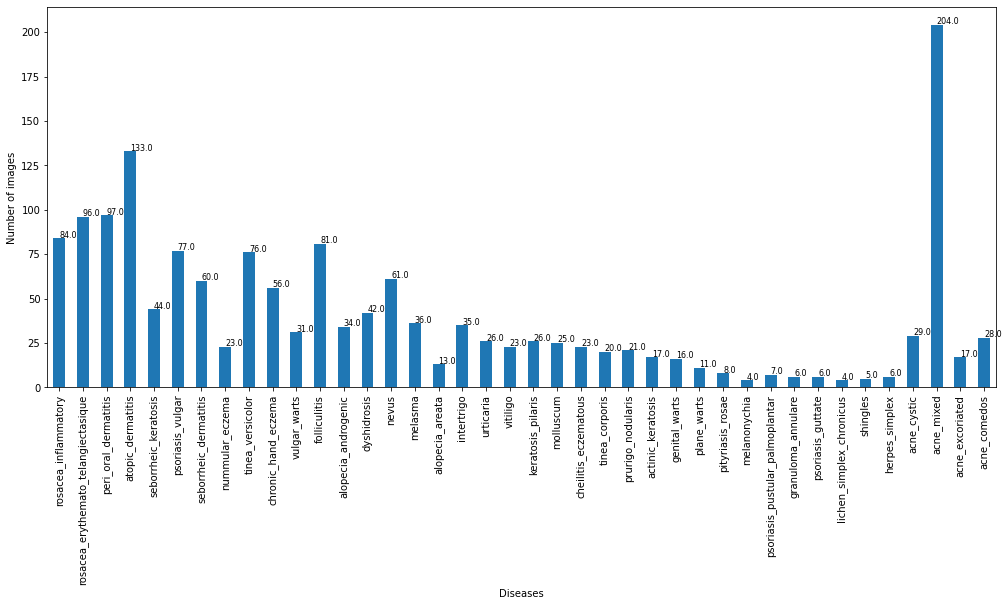

In [558]:
plt.figure(figsize=(17,7))
df_preds[columns].sum().plot(kind='bar')
plt.ylabel('Number of images')
plt.xlabel('Diseases')
for index, data in enumerate(df_preds[columns].sum()):
  plt.text(x=index, y=data+0.5, s=f'{data}', fontdict=dict(fontsize=8))
plt.show()

# 3. Identify all the images used to train the binary classifier, acne classifier and the 40 diseases classifier

In [559]:
df_preds['is_train'] = df_preds.apply(lambda x: x['is_train_40'] | x['is_train_binary'] | x['is_train_acne'], axis=1)
print(f'{df_preds.shape[0]} images in the final test set.')

1630 images in the final test set.


In [560]:
df_preds =df_preds[df_preds['is_train']==False].reset_index(drop=True)
print(f'{df_preds.shape[0]} images in the final test set.')

1630 images in the final test set.


let's take a look at the skin ratio of the images in the test set.

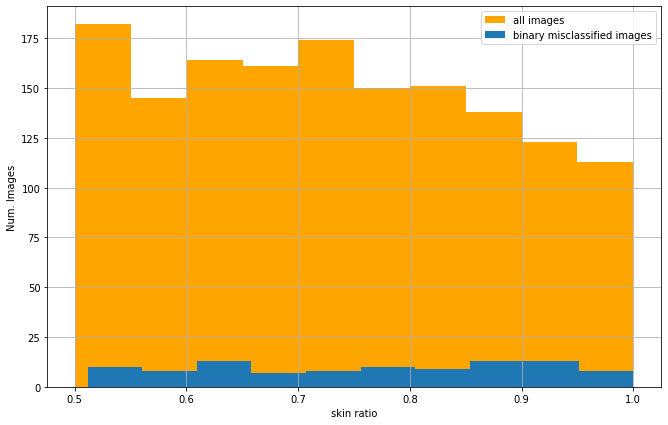

In [561]:
plt.figure(figsize=(11,7))
plt.xlabel('skin ratio')
plt.ylabel('Num. Images')
df_preds.ratios.hist(color='orange', label='all images')
df_preds[df_preds['label']!=df_preds['predicted']].ratios.hist(label='binary misclassified images')
plt.legend()
plt.show()


# 4. Current Pipeline Performance



Here, all the images in the test set are fed directly to the 40-diseases classifier. 

In [562]:
def get_top_3_performance(df):
    #df = df[df['Pred1'].isnull()==False].reset_index(drop=True)
    df['top3_prediction'] = df.apply(lambda row: bool(set([row['labels']]).intersection(set(row[['Pred1', 'Pred2', 'Pred3']].values))), axis=1)
    print(f"The 40 diseases classifier predicted correctly the true disease in the top-3 predictions of {df['top3_prediction'].value_counts()[True]} out of the {df.shape[0]} images.  --> {df['top3_prediction'].value_counts()[True]/df.shape[0]:0.3f}%.")
    return df.reset_index()
def get_top_3_classification_report(df_tmp):
    y_pred = df_tmp.apply(lambda x : x['labels'] if x['top3_prediction'] else x['Pred1'] , axis=1).to_list()
    y_score =df_tmp.apply(lambda x : x['labels'], axis=1).to_list()
    print(classification_report( y_score,y_pred,digits=4))
    return classification_report( y_score,y_pred,digits=4, output_dict=True)

In [563]:
df_preds_all = get_top_3_performance(df_preds)
report = get_top_3_classification_report(df_preds_all.reset_index(drop=True))
#pd.DataFrame(report).transpose().to_csv('41-diseases_top_3_report.csv')

The 40 diseases classifier predicted correctly the true disease in the top-3 predictions of 1408 out of the 1630 images.  --> 0.864%.
                                     precision    recall  f1-score   support

                       acne_comedos     0.7308    0.6552    0.6909        29
                        acne_cystic     0.9714    0.7727    0.8608        44
                    acne_excoriated     0.8000    0.6316    0.7059        19
                         acne_mixed     0.9529    0.9000    0.9257       180
                         acne_scars     0.9412    0.8000    0.8649        20
                  actinic_keratosis     0.8462    0.6471    0.7333        17
                alopecia_androgenic     0.9697    0.9412    0.9552        34
                    alopecia_areata     0.7333    0.8462    0.7857        13
                  atopic_dermatitis     0.8468    0.8077    0.8268       130
               cheilitis_eczematous     0.8095    0.7727    0.7907        22
                ch

# 5. Proposed Pipeline Performance
Here, we analyze the binary classifier predictions to see how confident the model is. 

Then, the images where the model is not confident enough are sent to the 40 diseases classifier along with the images that were classified as 'not_acne.'

In [564]:
def plot_misclassified_bar_chart(df_preds, df_misclassify, columns, misclassified_label='acne', fig_size= 7 ):    
    if misclassified_label=='acne':
         label='not_acne'
    else:
        label='acne'
    plt.figure(figsize=(23,fig_size))
    all_values= df_preds[df_preds['label']==label][columns].sum().sort_values(ascending=False)
    all_values= all_values[all_values!=0]
    values = df_misclassify[df_misclassify['predicted']==misclassified_label][columns].sum()
    for idx in all_values.index:
        if idx not in values:
            values = values.append(pd.Series([0],[idx]))
    values= values[all_values.index]
    all_values.plot(kind='bar', label= f'all {label} images', color='orange')
    values.plot(kind='bar', label= f'misclassified {label} images', color='b')
    plt.ylabel('Num of Images')
    plt.xlabel(f'{label} disease')
    for index, data in enumerate(values):
        if data!=0:
            plt.text(x=index, y=data+0.1, s=f'{data}', fontdict=dict(fontsize=10))

    for index, data in enumerate(all_values):
        plt.text(x=index, y=data+0.1, s=f'{data}', fontdict=dict(fontsize=10))
    plt.legend()
    plt.show()

In [565]:
def get_performance_based_confidence(df_preds, label_coln= 'label', pred_coln= 'predicted', 
                                     prob_acne_coln='prob_acne', prob_not_acne_coln='prob_not_acne', 
                                     acne_confidence = 0.5, not_acne_confidence = 0.5):
    masks = (df_preds[prob_acne_coln] < acne_confidence) & (df_preds[prob_not_acne_coln] < not_acne_confidence)
    df_prob =  df_preds.copy()
    df_prob = df_prob[~masks]
    #print(df_preds[masks])
    print(f'test images not confident enough: {df_preds.shape[0]-df_prob.shape[0]}/{df_preds.shape[0]}')
    matrix = confusion_matrix(df_prob[label_coln], df_prob[pred_coln])
    index = ['acne', 'not_acne', ]
    df_cm = pd.DataFrame(matrix, index=index, columns=index)
    f = plt.figure()
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    print(classification_report(df_prob[label_coln], df_prob[pred_coln], target_names=index, digits=4, output_dict=False))
    return masks 

Let's visualize the confusion matrix of the binary classifier.

test images not confident enough: 0/1630
              precision    recall  f1-score   support

        acne     0.7908    0.8801    0.8331       292
    not_acne     0.9732    0.9492    0.9610      1338

    accuracy                         0.9368      1630
   macro avg     0.8820    0.9147    0.8970      1630
weighted avg     0.9405    0.9368    0.9381      1630



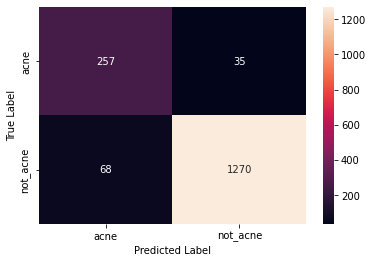

In [566]:
is_discarded = get_performance_based_confidence(df_preds, acne_confidence = 0.5, not_acne_confidence = 0.5)

Let's generate the bar chart visualizing the misclassifed images. 

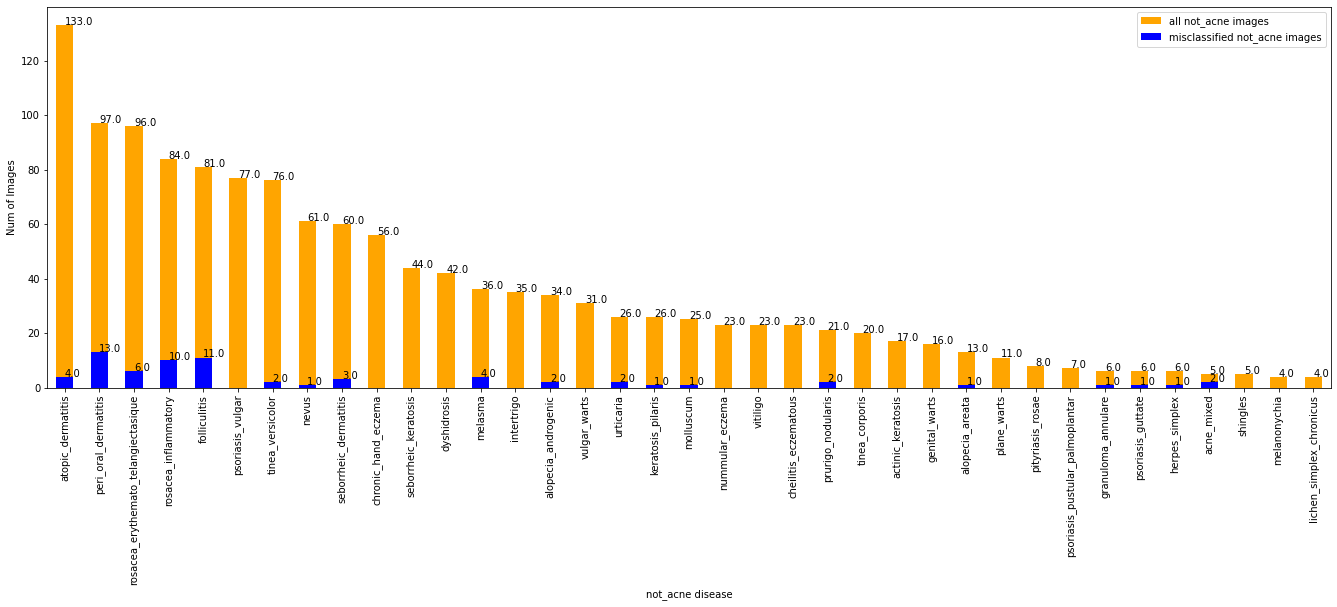

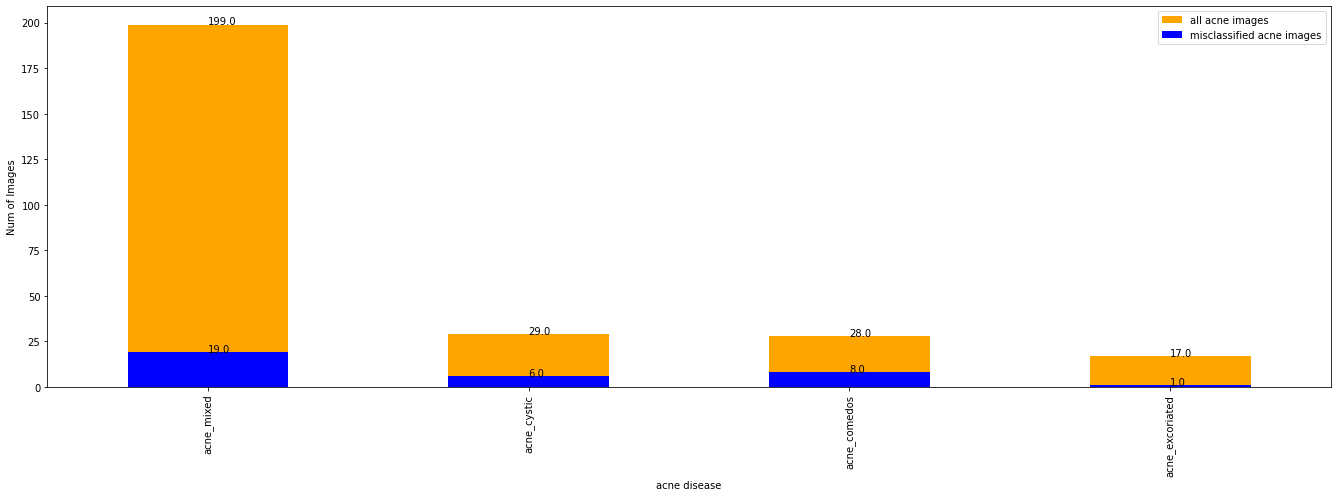

In [567]:
df_misclassify = df_preds[df_preds['label']!=df_preds['predicted']].reset_index(drop=True)

plot_misclassified_bar_chart(df_preds, df_misclassify, columns, misclassified_label='acne' )
plot_misclassified_bar_chart(df_preds, df_misclassify, columns, misclassified_label='not_acne' )


Let's only consider the images where the model is highly confident (acne confidence >99%)

test images not confident enough: 89/1630
              precision    recall  f1-score   support

        acne     0.8771    0.8554    0.8661       242
    not_acne     0.9732    0.9777    0.9754      1299

    accuracy                         0.9585      1541
   macro avg     0.9251    0.9165    0.9208      1541
weighted avg     0.9581    0.9585    0.9583      1541



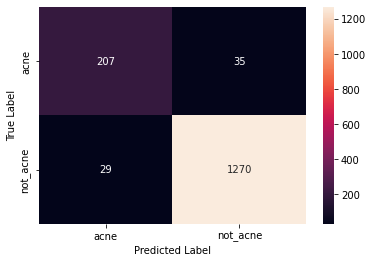

In [568]:
is_discarded = get_performance_based_confidence(df_preds, acne_confidence = 0.99, not_acne_confidence = 0.5)

In [569]:
df_preds['is_discarded']= is_discarded
print(f"There are {df_preds[df_preds['is_discarded']==True].shape[0]} images where the model is not confident enough in its predicitons. Those images are sent to the 40 diseases classifier")

There are 89 images where the model is not confident enough in its predicitons. Those images are sent to the 40 diseases classifier


## 5.1 Images with low confidence 

In [570]:
df_discarded = df_preds[df_preds['is_discarded']==True]
print(f"There are {df_discarded.shape[0]} with low confidence. Those images are sent to the 40 diseases classifier. ")
df_discarded = get_top_3_performance(df_discarded)

There are 89 with low confidence. Those images are sent to the 40 diseases classifier. 
The 40 diseases classifier predicted correctly the true disease in the top-3 predictions of 69 out of the 89 images.  --> 0.775%.


## 5.2 Images Classified as 'NOT ACNE'

In [571]:
df_not_acne = df_preds[(df_preds['is_discarded']==False) & (df_preds['predicted']=='not_acne')]
print(f"There are {df_not_acne.shape[0]} that were classified as 'not_acne'. Those images are also sent to the 40 diseases classifier. ")
df_not_acne = get_top_3_performance(df_not_acne)

There are 1305 that were classified as 'not_acne'. Those images are also sent to the 40 diseases classifier. 
The 40 diseases classifier predicted correctly the true disease in the top-3 predictions of 1137 out of the 1305 images.  --> 0.871%.


## 5.3 Images Classified as 'ACNE'

In [572]:
df_preds_acne = df_preds[(df_preds['is_discarded']==False) & (df_preds['predicted']=='acne')].reset_index(drop=True)

In [573]:
df_preds_acne['Pred1'] ='acne_mixed'
df_preds_acne['Pred2']= df_preds_acne[['prob_acne_comedos', 'prob_acne_cystic', 'prob_acne_excoriated', 'prob_acne_scars']].apply(lambda x: x.sort_values(ascending=False).index[0].replace('prob_', ''), axis=1)
df_preds_acne['Pred3']= df_preds_acne[['prob_acne_comedos', 'prob_acne_cystic', 'prob_acne_excoriated', 'prob_acne_scars']].apply(lambda x: x.sort_values(ascending=False).index[1].replace('prob_', ''), axis=1)

In [574]:
df_preds_acne = get_top_3_performance(df_preds_acne)
_ = get_top_3_classification_report(df_preds_acne)

The 40 diseases classifier predicted correctly the true disease in the top-3 predictions of 202 out of the 236 images.  --> 0.856%.
                                     precision    recall  f1-score   support

                       acne_comedos     1.0000    1.0000    1.0000         6
                        acne_cystic     1.0000    0.9697    0.9846        33
                    acne_excoriated     1.0000    0.7857    0.8800        14
                         acne_mixed     0.8046    1.0000    0.8917       140
                         acne_scars     1.0000    0.9286    0.9630        14
                  atopic_dermatitis     0.0000    0.0000    0.0000         1
                       folliculitis     0.0000    0.0000    0.0000         6
                 granuloma_annulare     0.0000    0.0000    0.0000         1
                     herpes_simplex     0.0000    0.0000    0.0000         1
                            melasma     0.0000    0.0000    0.0000         2
                    

Let's visualize all the misclassfied images (by the acne classifier)

In [579]:
#df_preds_acne[df_preds_acne['top3_prediction']==False][['prob_acne_comedos', 'prob_acne_cystic', 'prob_acne_excoriated', 'prob_acne_scars', 'labels', 'Pred1', 'Pred2', 'Pred3','top3_prediction']]

## 5.4 Proposed pipeline performance (all predictions combined)

In [580]:
df_all = pd.concat((df_not_acne, df_discarded, df_preds_acne))
report= get_top_3_classification_report(df_all)

                                     precision    recall  f1-score   support

                       acne_comedos     0.7778    0.7241    0.7500        29
                        acne_cystic     1.0000    0.8864    0.9398        44
                    acne_excoriated     0.8750    0.7368    0.8000        19
                         acne_mixed     0.8350    0.9556    0.8912       180
                         acne_scars     1.0000    0.8500    0.9189        20
                  actinic_keratosis     0.8462    0.6471    0.7333        17
                alopecia_androgenic     0.9697    0.9412    0.9552        34
                    alopecia_areata     0.7333    0.8462    0.7857        13
                  atopic_dermatitis     0.8595    0.8000    0.8287       130
               cheilitis_eczematous     0.8095    0.7727    0.7907        22
                chronic_hand_eczema     0.9615    0.9091    0.9346        55
                        dyshidrosis     0.8889    0.9524    0.9195        4

In [577]:
#pd.DataFrame(report).transpose().to_csv('proposed_pipeline_confidence_cec_0.99_top_3_report.csv')